In [1]:
import numpy as np
import scipy.ndimage
plt.style.use("default")
import time

## Generating a latent space representation
To make it more "understandable" where material is placed we generate a slowly varying landscape by interpolation of a low resolution map.

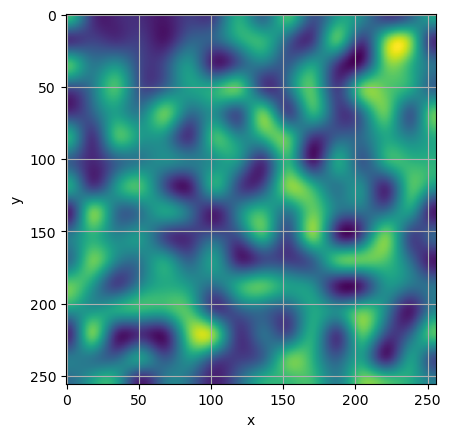

In [9]:
features = 16
zoom = 16
heatmap = np.random.random((features,features))-0.5
large_heatmap = scipy.ndimage.zoom(heatmap, zoom)
plt.imshow(large_heatmap)
plt.xlabel("x")
plt.ylabel("y")
plt.grid()

N=features*zoom

## Generating the brush

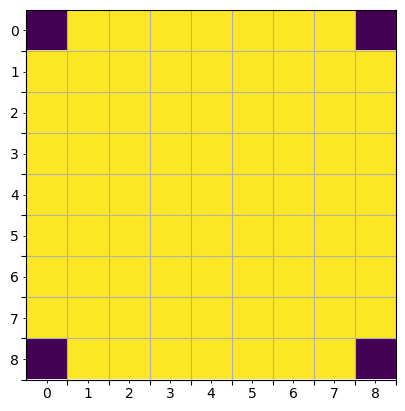

In [10]:
kernel_size=9
brush = np.ones((kernel_size, kernel_size))
brush[0,0] = 0
brush[0,-1] = 0
brush[-1,0] = 0
brush[-1,-1] = 0
brush = brush.astype(bool)

def show_brush(brush):
  nx, ny = brush.shape
  plt.imshow(brush)
  ax = plt.gca()
  ax.set_yticks(np.arange(nx)+0.5)
  ax.set_yticklabels(["" for i in range(nx)])
  ax.set_xticks(np.arange(ny)+0.5)
  ax.set_xticklabels(["" for i in range(ny)])
  ax.set_yticks(np.arange(nx), minor=True)
  ax.set_yticklabels([f"{i}" for i in range(nx)], minor=True)
  ax.set_xticks(np.arange(ny), minor=True)
  ax.set_xticklabels([f"{i}" for i in range(ny)], minor=True)
  plt.grid()

show_brush(brush)

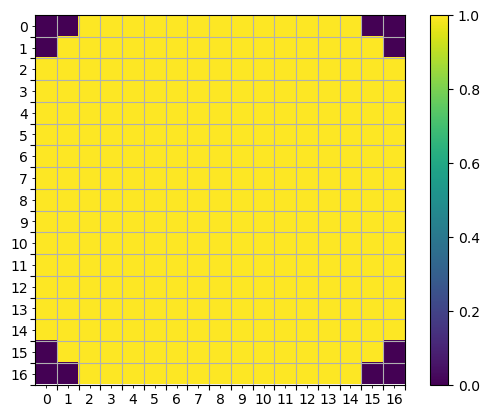

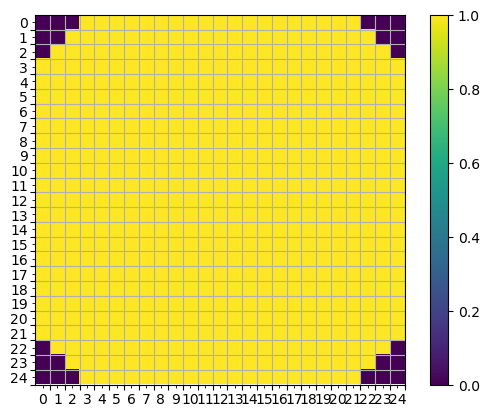

In [11]:
conv_brush = scipy.ndimage.convolve(np.pad(brush, len(brush)//2), brush)
show_brush(conv_brush)
plt.colorbar()

plt.figure()
double_conv_brush = scipy.ndimage.convolve(np.pad(conv_brush, len(brush)//2), brush)
show_brush(double_conv_brush)
plt.colorbar()

## Running the Generator

In [12]:
def dilate(img, brush):
    global time_dilate
    time_dilate -= time.process_time() 
    dil = scipy.ndimage.binary_dilation(img, brush)
    time_dilate += time.process_time() 
    return dil

# def existing_pixels(touches, brush):
#     return dilate(touches, brush)

# def impossible_touches(existing_other, brush): # TODO avoid dilate
#     return dilate(existing_other, brush)

def valid_touches(impossible, touches):
    return np.logical_and(np.logical_not(impossible), np.logical_not(touches))

def possible_pixels(valid, touches, brush): # TODO avoid dilate
    possible_touches = np.logical_or(touches, valid)
    # equivalent to touches or (not impossible)
    # because all touches must be possible: it is simply equivalent to not impossible.
    return dilate(possible_touches, brush)

def required_pixels(existing, possible_other):
    return np.logical_and(np.logical_not(existing), np.logical_not(possible_other))

def resolving_touches(required, valid, brush): # TODO avoid dilate
    return np.logical_and(dilate(required, brush), valid)

def free_touches(possible_other, existing_other, valid, brush):
    dilated = dilate(np.logical_or(possible_other, existing_other), brush)
    return np.logical_and(np.logical_not(dilated), valid)


def select_single(s_valid, v_valid, s_suggest, v_suggest, brush, t_s, t_v, p_s_existing, p_v_existing, t_s_impossible, t_v_impossible, p_s_possible, p_v_possible):
    global time_convolute
    time_convolute -= time.process_time() 
    s_weights = scipy.ndimage.convolve(s_suggest, brush) # TODO eliminate this convolution!
    v_weights = -scipy.ndimage.convolve(v_suggest, brush)
    time_convolute += time.process_time() 

    s_weights[np.logical_not(s_valid)] = np.nan
    v_weights[np.logical_not(v_valid)] = np.nan

    max_s = max_v = -np.inf
    if s_valid.any():
        max_pos_s = np.nanargmax(s_weights)
        max_s = s_weights.flat[max_pos_s]
    
    if v_valid.any():
        max_pos_v = np.nanargmax(v_weights)
        max_v = v_weights.flat[max_pos_v]

    if  max_s > max_v:
      touch(max_pos_s, brush, t_s, p_s_existing, t_v_impossible, p_v_possible)
    else:
      touch(max_pos_v, brush, t_v, p_v_existing, t_s_impossible, p_s_possible)

def touch(flat_index, brush, touches, existing, other_impossible, other_possible_pixels, track_possible=True, conv_brush=conv_brush): # TODO pull up conv_brush
  """Perform a touch on the given index of the flattened map and track the consequences"""
  touches.flat[flat_index] = True
  track(existing, flat_index, brush)
  track(other_impossible, flat_index, conv_brush)

  if track_possible:
    if debug>1:
      plt.figure(figsize = (6,6))
      plt.subplot(221)
      plt.title("Possible Pixels before")
      plt.imshow(other_possible_pixels,  vmax=1, vmin=0)
      idx = np.unravel_index(flat_index, other_possible_pixels.shape)
      plt.scatter([idx[1]],[idx[0]], s=1)
      plt.imshow(touches,  vmax=1, vmin=0, alpha=0.3*touches, cmap="jet")
    track(other_possible_pixels, flat_index, double_conv_brush, invert=True)
    
    if debug>1:
      plt.subplot(222)
      plt.title("Possible Pixels penalized")
      plt.imshow(other_possible_pixels,  vmax=1, vmin=0)
      idx = np.unravel_index(flat_index, other_possible_pixels.shape)
      plt.scatter([idx[1]],[idx[0]], s=1)
      plt.imshow(touches,  vmax=1, vmin=0, alpha=0.3*touches, cmap="jet")

    local_dilate(np.logical_not(other_impossible), flat_index, brush, other_possible_pixels)


def local_dilate(img, pos, brush, res):
  l = len(brush)*2
  idx = np.unravel_index(pos, img.shape)
  
  dw = [min(l, idx_i) for idx_i in idx] #from the brushcenter how many pixels "down" the axis
  up = [min(l+1, max(l_img - idx_i, 0)) for (idx_i, l_img) in zip(idx, img.shape)]

  print("up_down:", up, dw)

  slice_image = np.s_[
    idx[0]-dw[0]:idx[0]+up[0], 
    idx[1]-dw[1]:idx[1]+up[1]
  ]

  res[slice_image] |= dilate(img[slice_image], brush)

  if debug>1:
    plt.subplot(223)
    plt.title("Not Impossible Touches")
    plt.imshow(img[slice_image], vmax=1, vmin=0)
    plt.subplot(224)
    plt.title("Possible Pixels after")
    plt.imshow(res[slice_image], vmax=1, vmin=0)
  

def track(img, pos, brush, invert=False):
  l = len(brush)//2
  idx = np.unravel_index(pos, img.shape)

  # slightly complicated :/
  dw = [min(l, idx_i) for idx_i in idx] #from the brushcenter how many pixels "down" the axis
  up = [min(l+1, max(l_img - idx_i, 0)) for (idx_i, l_img) in zip(idx, img.shape)]
  slice_image = np.s_[
    idx[0]-dw[0]:idx[0]+up[0], 
    idx[1]-dw[1]:idx[1]+up[1]
  ]
  slice_brush = np.s_[
    l -dw[0]:l+up[0],
    l -dw[1]:l+up[1],
  ]
  if not invert:
    img[slice_image] |= brush[slice_brush]
  else:
    img[slice_image] &= ~brush[slice_brush]

debug = 1
def log(*args):
  if debug:
    print(*args)

opt_track_existing = True

def generate():
  time_update = 0
  time_select = 0 
  global time_dilate
  time_dilate = 0
  global time_convolute
  time_convolute = 0
  time_existing = 0
  time_impossible = 0
  time_valid = 0
  time_possible = 0
  time_required = 0
  time_resolving = 0
  time_free = 0

  s_suggest = large_heatmap.copy()
  v_suggest = large_heatmap.copy()

  t_s = np.zeros_like(s_suggest).astype(bool)
  t_v            = t_s.copy()
  p_s_existing   = t_s.copy()
  p_v_existing   = t_s.copy()
  t_s_impossible = t_s.copy()
  t_v_impossible = t_s.copy()
  t_s_valid = valid_touches(t_s_impossible, t_s)
  t_v_valid = valid_touches(t_v_impossible, t_v)
  p_s_possible = np.ones_like(s_suggest).astype(bool)
  p_v_possible = np.ones_like(s_suggest).astype(bool)



  for i in range(N**2): #N**2
      time_update -= time.process_time() 

      s_suggest[p_s_existing] = 0
      v_suggest[p_v_existing] = 0

      if debug>1:
        time_possible -= time.process_time() 
        p_s_possible_real = possible_pixels(t_s_valid,t_s,brush)
        p_v_possible_real = possible_pixels(t_v_valid,t_v,brush)
        time_possible += time.process_time() 

        compare_s = np.logical_xor(p_s_possible,p_s_possible_real)
        compare_v = np.logical_xor(p_v_possible,p_v_possible_real)

        if compare_s.any() or compare_v.any():
          plt.figure(figsize = (6,9))
          plt.subplot(321)
          plt.title("Compare Solid")
          plt.imshow(compare_s, vmax=1, vmin=0)
          plt.subplot(322)
          plt.title("Compare Void")
          plt.imshow(compare_v, vmax=1, vmin=0)
          plt.subplot(323)
          plt.title("Possible Solid")
          plt.imshow(p_s_possible, vmax=1, vmin=0)
          plt.subplot(324)
          plt.title("Possible Void")
          plt.imshow(p_v_possible, vmax=1, vmin=0)
          plt.subplot(325)
          plt.title("Actual Possible Solid")
          plt.imshow(p_s_possible_real, vmax=1, vmin=0)
          plt.subplot(326)
          plt.title("Actual Possible Void")
          plt.imshow(p_v_possible_real, vmax=1, vmin=0)
          plt.show()
          raise ValueError("Calculation of possible wrong")

      time_free -= time.process_time() 
      t_s_free = free_touches(p_v_possible, p_v_existing, t_s_valid, brush)
      t_v_free = free_touches(p_s_possible, p_s_existing, t_v_valid, brush)
      time_free += time.process_time() 

      if not(t_s_free.any() or t_v_free.any()): # only required if no fre touches are available
        time_required -= time.process_time() 
        p_s_required = required_pixels(p_s_existing, p_v_possible)
        p_v_required = required_pixels(p_v_existing, p_s_possible)
        time_required += time.process_time() 

        time_resolving -= time.process_time() 
        t_s_resolving = resolving_touches(p_s_required, t_s_valid, brush)
        t_v_resolving = resolving_touches(p_v_required, t_v_valid, brush)
        time_resolving += time.process_time() 

      time_update += time.process_time() 
      time_select -= time.process_time() 

      if t_s_free.any() or t_v_free.any():
          log(f"{i}: free: {t_s_free.sum()}; {t_v_free.sum()}")

          flat_free_s = np.where(t_s_free.flatten())[0]
          flat_free_v = np.where(t_v_free.flatten())[0]
          
          time_existing -= time.process_time() 
          for idx in flat_free_s:
            touch(idx, brush, t_s, p_s_existing, t_v_impossible, p_v_possible, track_possible=False)
          
          for idx in flat_free_v:
            touch(idx, brush, t_v, p_v_existing, t_s_impossible, p_s_possible, track_possible=False)
          time_existing += time.process_time() 

      elif t_s_resolving.any() or t_v_resolving.any():
          log(f"{i}: resolving")
          select_single(
            t_s_resolving, t_v_resolving, s_suggest, v_suggest, brush, t_s, t_v, 
            p_s_existing, p_v_existing, t_s_impossible, t_v_impossible, p_s_possible, p_v_possible)
      elif t_s_valid.any() or t_v_valid.any():
          log(f"{i}: valid")
          select_single(
            t_s_valid, t_v_valid, s_suggest, v_suggest, brush, t_s, t_v, 
            p_s_existing, p_v_existing, t_s_impossible, t_v_impossible, p_s_possible, p_v_possible)
      else:
          print("finished")
          time_select += time.process_time() 
          break

      time_select += time.process_time() 

      time_valid -= time.process_time() 
      t_s_valid = valid_touches(t_s_impossible, t_s)
      t_v_valid = valid_touches(t_v_impossible, t_v)
      time_valid += time.process_time() 


  plt.figure(figsize = (6,6))
  plt.subplot(221)
  plt.title("Solid and Void")
  plt.imshow(p_s_existing)
  plt.subplot(222)
  plt.title("Solid and Void Touches")
  plt.imshow(t_s.astype(int)-t_v)
  plt.subplot(223)
  plt.imshow(large_heatmap)

  return dict(
    update = time_update,
    impossible = time_impossible,
    valid = time_valid,
    possible = time_possible,
    required = time_required,
    resolving = time_resolving,
    free = time_free,
    select = time_select,
    existing = time_existing,
    convolute = time_convolute,
    dilate = time_dilate
  )

0: valid
up_down: [19, 19] [18, 18]
1: valid
up_down: [19, 19] [18, 18]
2: valid
up_down: [19, 19] [18, 18]
3: resolving
up_down: [19, 19] [18, 18]
4: free: 17; 0
5: valid
up_down: [19, 19] [18, 18]
6: valid
up_down: [19, 19] [18, 18]
7: valid
up_down: [19, 19] [18, 18]
8: valid
up_down: [19, 19] [11, 18]
9: valid
up_down: [19, 19] [18, 18]
10: valid
up_down: [19, 19] [18, 18]
11: valid
up_down: [19, 19] [2, 18]
12: free: 0; 10
13: valid
up_down: [19, 19] [18, 18]
14: valid
up_down: [19, 19] [18, 18]
15: valid
up_down: [19, 19] [18, 18]
16: valid
up_down: [1, 19] [18, 18]
17: valid
up_down: [19, 18] [18, 18]
18: resolving
up_down: [19, 19] [14, 18]
19: free: 19; 0
20: valid
up_down: [19, 19] [18, 18]
21: valid
up_down: [19, 19] [18, 0]
22: valid
up_down: [19, 19] [18, 18]
23: valid
up_down: [19, 19] [18, 18]
24: valid
up_down: [19, 19] [0, 18]
25: valid
up_down: [19, 19] [18, 18]
26: valid
up_down: [19, 19] [18, 18]
27: resolving
up_down: [19, 19] [18, 18]
28: free: 0; 19
29: valid
up_

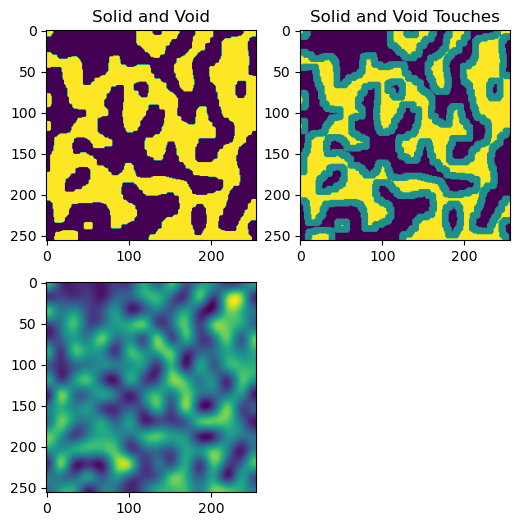

In [13]:
times = generate()

In [14]:
times["update"]+times["select"]

37.69281400000011

No tracking: 6.94s

With tracking: 6.09s

With full tracking: 5.72s

In [15]:
times

{'update': 25.78560100000003,
 'impossible': 0,
 'valid': 0.061675000000185776,
 'possible': 0,
 'required': 0.032045000000032076,
 'resolving': 16.440276999999917,
 'free': 9.027544999999911,
 'select': 11.907213000000084,
 'existing': 0.602782000000019,
 'convolute': 10.152492999999886,
 'dilate': 25.586762000000398}